In [1]:
import os
import glob
import time
# import silence_tensorflow
# silence_tensorflow.silence_tensorflow()
import warnings
warnings.filterwarnings('ignore')
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, train_y), (test_x, _) = cifar10.load_data()

train_x.shape

170500096/170498071 [==============================] - 4s 0us/step


(50000, 32, 32, 3)

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(50000, 32, 32, 3)

In [6]:
train_x = train_x.astype('float32')
train_x.shape

(50000, 32, 32, 3)

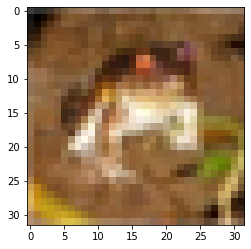

In [7]:
plt.imshow((train_x[0]*127.5 +127.5).astype("int16"))
# plt.colorbar()
plt.show()

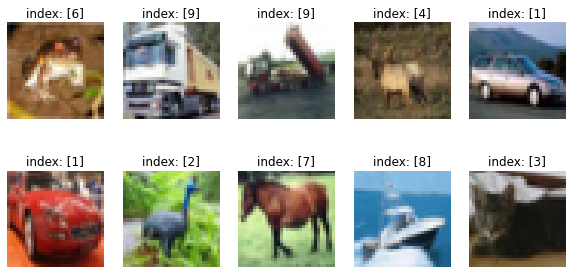

In [8]:
plt.figure(figsize=(10, 5))
def unorm(output_):
    # output_ = output_.numpy()
    output_ = (output_*127.5 + 127.5).astype("int16")
    return output_

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(unorm(train_x[i]))
    plt.title(f'index: {train_y[i]}')
    plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

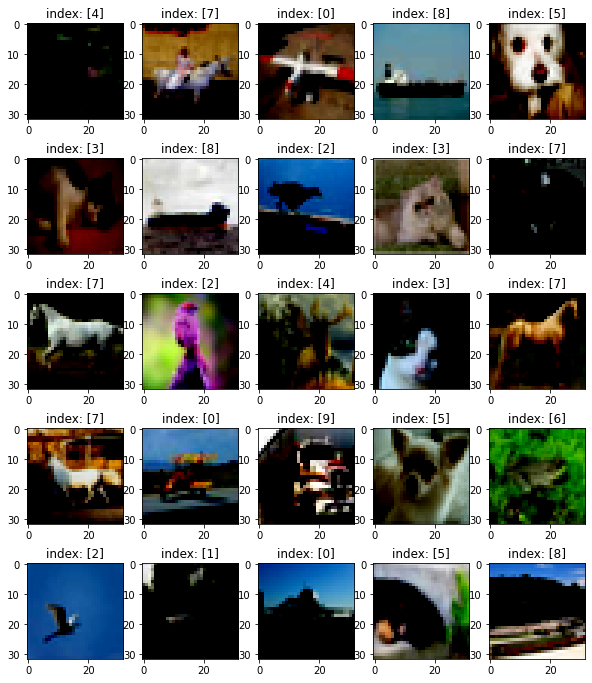

In [11]:
plt.figure(figsize=(10, 12))
X = np.random.randint(0,50000, 25)
for i in range(25):
    # [[MY CODE]]
    plt.subplot(5,5,i+1)
    plt.imshow(train_x[X[i]])
    plt.title(f'index: {train_y[X[i]]}')
    
plt.show()

In [12]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
y = tf.zeros((50000,11)).numpy()
for i,j in enumerate(train_y):
    y[i,j] = 1

train_y_dataset = tf.data.Dataset.from_tensor_slices(y).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [15]:
input_ = np.arange(7*7*256).reshape(1,7,7,256).astype(np.float32)

layer = layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False)
layer(input_).shape

TensorShape([1, 14, 14, 64])

### 위 모형은 Conv2DTranspose에서 무슨일이 일어나고 있는지 단적으로 보여주는 예시이다. 자세히 알고싶으면 [여기](https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11)서 알 수 있다. 조금만 더 설명하자면 원래 이미지를 넓게 퍼뜨리고 사이사이에 패딩을 집어넣는다. 이상태에서, convolution layer를 통과시킨다.

### 이를 이용해서, 모델을 만들어보도록 하겠다.

In [16]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [17]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [18]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.6940066 , -0.46558136,  0.6601648 ,  1.9100888 , -2.1907442 ,
        -0.63772   , -0.36624363, -0.6044781 ,  0.27485126,  0.02330942,
        -0.847548  ,  1.7823286 , -0.0697624 ,  0.3121705 ,  0.15089728,
        -0.8411906 , -0.33372006, -0.9301126 ,  0.37940112,  0.21959113,
        -1.9196829 , -0.9871211 , -0.3851572 , -0.42002013, -0.8343869 ,
         1.82521   ,  0.16472076, -1.0273329 , -1.2540354 ,  3.3573961 ,
         1.001335  , -0.19134434,  1.0828207 , -0.7104884 , -1.5462855 ,
         0.8802807 ,  0.4836822 ,  1.4459021 , -0.62869275, -0.6914886 ,
         0.85383606,  1.2188973 , -0.0082637 ,  0.7015788 ,  0.1983614 ,
        -0.03132503, -0.7926941 ,  0.94410676,  0.0843532 , -1.6606759 ,
         0.29103944, -1.6505378 ,  0.77959836,  0.04917243,  0.37040234,
        -1.1615995 , -1.3029642 , -1.2822028 ,  0.29481095,  0.74696934,
        -0.24508855,  1.0739452 , -0.5453957 ,  0.07448838, -0.76263183,
 

In [19]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


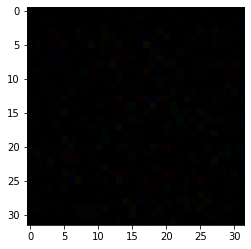

In [20]:
plt.imshow(generated_image[0, :, :, :])
# plt.colorbar()
plt.show()

In [21]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(11, activation = 'softmax'))
    # model.add(layers.Softmax())

    return model


In [22]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        12832     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)       

In [23]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 11), dtype=float32, numpy=
array([[0.09122794, 0.09082966, 0.09114224, 0.09077659, 0.09094024,
        0.09082542, 0.09118111, 0.09079719, 0.09088807, 0.09065118,
        0.09074037]], dtype=float32)>

In [24]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
sap_cross = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [25]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.reduce_max(tf.constant(vector),axis=1)
int(True)
int(tf.constant(vector)[1,2] == 6)

1

### fake_output과 real_output을 각각 1 또는 0에 비교를 해야 하는데, 어떻게 비교할 수 있을까요?

### 바로 tf.ones_like()와 tf.zeros_like() 함수를 활용하면 됩니다.

In [54]:
def generator_loss(fake_output,fake_fake_label):
    return cross_entropy(fake_fake_label, fake_output)

In [55]:
def discriminator_loss(real_output, fake_output, label_, fake_label):
    real_loss = sap_cross(label_, real_output)
    fake_loss = cross_entropy(fake_label, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [56]:
def discriminator_accuracy(real_output, fake_output):
#     real_total = np.zeros(BATCH_SIZE)
#     fake_total = np.zeros(BATCH_SIZE)
#     real = tf.reduce_max(real_output,axis=1)
#     fake = tf.reduce_max(fake_output,axis=1)
#     for i in range(BATCH_SIZE):
#         real_total[i] = int(real_output[i,10] != real[i])
#         fake_total[i] = int(fake_output[i,10] == fake[i])
        
#     real_accuracy = tf.reduce_mean(real_total)
#     fake_accuracy = tf.reduce_mean(fake_total)
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.less(real_output[:,-1], tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(fake_output[:,-1], tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [86]:
generator_optimizer = tf.keras.optimizers.Adam(2e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-5)

In [87]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [88]:
import numpy as np
import tensorflow as tf

def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([7, 7])

In [89]:
import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

In [90]:
@tf.function
def train_step(images, label_):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    fake_label = np.zeros((BATCH_SIZE,11))
    for i in fake_label:
        i[-1]=1
    fla = tf.constant(fake_label)

    fake_fake_label = np.ones((BATCH_SIZE,11))
    for i in fake_fake_label:
        i[-1]=0
    fafla = tf.constant(fake_fake_label)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        
        gen_loss = generator_loss(fake_output,fafla)
        disc_loss = discriminator_loss(real_output, fake_output, label_, fla)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [91]:
def unorm(output_):
    output_ = output_.numpy()
    output_ = (output_*127.5 + 127.5).astype("int16")
    return output_


def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(unorm(predictions[i]))
        plt.axis('off')
   
    plt.savefig('fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [92]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('fashion/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

In [93]:
checkpoint_dir = 'fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [94]:
def train(dataset,labels, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(zip(dataset,labels)):
            image_batch, label_ = image_batch
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch, label_)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))
                draw_train_history(history, epoch)

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [95]:
save_every = 5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

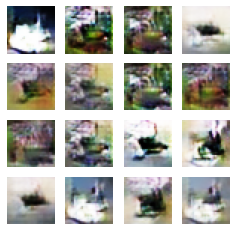

Time for training : 6553 sec


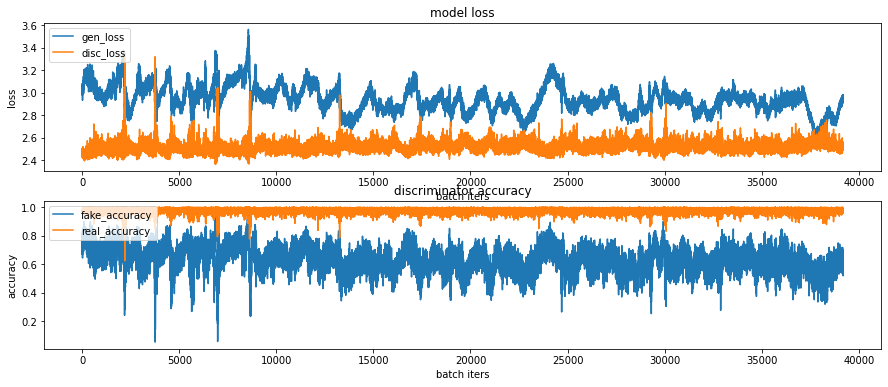

CPU times: user 1h 36min 45s, sys: 24min 5s, total: 2h 51s
Wall time: 1h 49min 16s


In [96]:
%%time
train(train_dataset,train_y_dataset, EPOCHS, save_every)


# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [ ]:
anim_file = 'fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('fashion/generated_samples/sample*.png'))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l fashion/fashion_mnist_dcgan.gif

In [19]:
# 추가 실험

cifar10 = tf.keras.datasets.cifar10

(train_x,y_train),(x_test,_) = cifar10.load_data()

x_train.shape

(50000, 32, 32, 3)